# Required Libraries  

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda
from keras.models import Model
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.constraints import max_norm 
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(3)                                                 
from scipy import interpolate

# Parameters Declaration 
Lenght of Message space, Number of bits per symbol, number of channel uses
and Rate of communication is defined here. 

In [2]:
L_o_m  = 16                                               # Lenght of Message space(M) given by 2^number of bits 
bits = np.log2(L_o_m)                                     # Number of bits 
bits = int(bits)                                          # Converting it to int 
n = 2                                                     # Number of channels(n) 
R = bits/n                                                # Communication rate(R) given by number of bits divided by number of channels

print ('Lenght of Message space (M):',L_o_m,'Number of bits (k):',bits,'Number of channels (n):',n)

Lenght of Message space (M): 16 Number of bits (k): 4 Number of channels (n): 2


# Generating training data

In [3]:
samples = 100000
labels = np.random.randint(L_o_m , size=samples)          # generating 100000 random numbers whose values are enclosed between 0 and (M-1)

# Performing Onehot Encoding
Each of the message in generated message space is onehot encoded. 

In [4]:
training_data = []                                        # Creating a empty list 
for i in labels:                         
    inp_vector = np.zeros(L_o_m)                          # Creating a numpy array of size M                                                    
    inp_vector[i] = 1                                     # Performing one hot encoding 
    training_data.append(inp_vector) 



In [5]:
training_data = np.array(training_data)                   # Transforming data to numpy array
print (training_data.shape)                               # Each of the sample out of the N generated samples is onehot encoded to vector of size M 

(100000, 16)


Verifying the one hot encoding performed on the generated data.  


In [6]:
check_list = [23,45,97,115,278,369]
for i in check_list:
    print(labels[i],training_data[i])

14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Defining the architecture of Autoencoder

In [7]:
input_signal = Input(shape=(L_o_m,))                              # After performing one hot encoding each input is vector of size M
encoded1 = Dense(L_o_m, activation='relu')(input_signal)          # First layer is dense layer with relu activation function and M nuerons  
encoded2 = Dense(n, activation='linear')(encoded1)                # Second layer is dense layer with linear activaton function and n_channel nuerons 
encoded3 = Lambda(lambda x: np.sqrt(n)*K.l2_normalize(x,axis=1))(encoded2)      
                                                                  # Normalisation is performed to met the physical constraints (Energy Constraint)
                                                                  #encoded3 = BatchNormalization(gamma_constraint=max_norm(1.4142136))(encoded2) 


EbNo_train = 5.01187                                              # coverted 7 db of EbNo
                                                                  # 10log(EbNo) = 7 db
encoded4 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)   # As Variance is given by (1/(2*R*EbNo_train) 
                                                                  # Gausian noise is added by this layer 

decoded1 = Dense(L_o_m, activation='relu')(encoded4)              # First layer of the decoder is dense layer with-
                                                                  # -relu activation function and total M nuerons

decoded2 = Dense(L_o_m, activation='softmax')(decoded1)           # Second layer of the decoder is dense layer with- 
                                                                  # -softmax activation function which outputs the probabilities 


autoencoder = Model(input_signal, decoded2)                       # Autoencoder model is defined here 
adam = Adam(learning_rate=0.001)                                  # Adam optimizer is used with learning rate 0.01 to minimise the loss 

autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')    
                                                                  # Autoencoder is compiled here and loss is defined as categorical crossentropy
                                                                  # between the onehot encoded input vector and the output of the decoder 

# Summary of Autoencoder

In [8]:
print (autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 2)                0         
 se)                                                             
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                             

# Training the model 

In [9]:
autoencoder.fit(training_data, training_data, epochs=150, batch_size=64)        # Autoencoder is fitted with the generated data                                         

Epoch 1/150
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2210
Epoch 2/150
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6247
Epoch 3/150
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5496
Epoch 4/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5375
Epoch 5/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5299
Epoch 6/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5301
Epoch 7/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5266
Epoch 8/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5296
Epoch 9/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5278
Epoch 10/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5256
Epoch 11/150
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5247
Epoch 12/150
1563/1563 [==============================] - 3s 2ms/step - lo

# Encoder

In [10]:
encoder = Model(input_signal, encoded3)                   # Model of Encoder is Defined here  

# Decoder 

In [11]:
encoded_input = Input(shape=(n,))                         # Model for decoder is defined here  

decoder_1 = autoencoder.layers[-2](encoded_input)         # Second last layer of the defined Autoencoder 
decoder_2 = autoencoder.layers[-1](decoder_1)             # Last layer of the defined Autoencoder 
decoder = Model(encoded_input, decoder_2)                                 

# Generating Test data 

In [12]:
test_samples = 10000                                      # Size of test samples 
                                                                                
test_labels = np.random.randint(L_o_m,size=test_samples)  # Test data of size 10000 is created with all values enclosed between 0 and M
test_data = []

for i in test_labels:
    test_vector = np.zeros(L_o_m)                         # Numpy array of size M is created with all entries equal to zero 
    test_vector[i] = 1                                    # performing One hot encoding on each entry of 10000
    test_data.append(test_vector)
    
test_data = np.array(test_data)                           # Test data is converted to numpy array 
print(test_data.shape)                                    # Shape of test_data is given by (10000*M)

(10000, 16)


In [13]:
test_num = 99                                             # Verifying the onehot encoding on generated test data 
print (test_data[test_num],test_labels[test_num])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 7


# Constellation Diagram
Every message in the message space is encode to draw constellation diagram 

In [14]:
scatter_plot = []                                                                
for i in range(0,L_o_m):                                  # For all the messages in the message space 
    array1 = np.zeros(L_o_m)                              # Generating numpy array of size (L_o_m) with all entries equal to zero 
    
    array1[i] = 1                                         # onehot encoding of the each message
    scatter_plot.append(encoder.predict(np.expand_dims(array1,axis=0)))      # Encoding every possible entry of Messages needed to be sent 
scatter_plot = np.array(scatter_plot)                     # As you can see for each of the sixteen possible values there is a complex representation 
print (scatter_plot.shape)

(16, 1, 2)


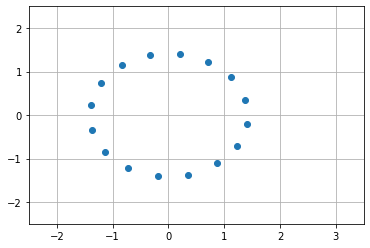

In [15]:
scatter_plot = scatter_plot.reshape(L_o_m,2,1)            # Constellation diagram
plt.scatter(scatter_plot[:,0],scatter_plot[:,1] )         # quadrature phase shift keying (QPSK) for (2,2)
plt.axis((-2.5,3.5,-2.5,2.5))                             # Rotated 16 PSK constellation for (2,4)

plt.grid()
plt.show()

# Calculating Bit Error Rate 

In [16]:
def frange(i, j, jump):                 # For represnting SNR after overy 0.5 db interval 
  while i < j:
    yield i
    i += jump

In [17]:
SNR_range = list(frange(-4,12,0.5))                             # Range of SNR 
print(len(SNR_range))                                           # In total there are 25 intervals
  
BER = [None]*len(SNR_range)                                                  
                                                 
for x in range(0,len(SNR_range)):                               # for each of the value of SNR 
    EbNo=10.0**(SNR_range[x]/10.0)                              # to covert each value of SNR from db's
    noise_std = np.sqrt(1/(2*R*EbNo))                           # Standard deviation of the added noise layer 
    mean = 0                                                    # Mean of the added noise layer 
    errors = 0
    
    noise = noise_std * np.random.randn(test_samples,n)         # Noise is added to encoded data
    encoded_vector = encoder.predict(test_data)                 # Encoded test data 
    noise_added_vector = encoded_vector + noise                 # Encoded test data + Noise

    decoded_vector =  decoder.predict(noise_added_vector)       # Decoded data 
    pred_output = np.argmax(decoded_vector,axis=1)         # As the decoder last layer is Softmax so the index with the highest probabilty is chosen
    errors = (pred_output != test_labels)                  # It checks for each of the test_sample is the predicted value is same as the original value 
    
    errors =  errors.astype(int).sum()                          # Adds up the total Error bits in each of the iteration for test_samples values  
        
    BER[x] = errors / test_samples                              # BER is given by total wrongly identified examples over total number of Examples

    print ('SNR (Signal to noise ratio):',SNR_range[x],'BER (Bit Error Rate):',BER[x])

32
SNR (Signal to noise ratio): -4 BER (Bit Error Rate): 0.7223
SNR (Signal to noise ratio): -3.5 BER (Bit Error Rate): 0.7088
SNR (Signal to noise ratio): -3.0 BER (Bit Error Rate): 0.6977
SNR (Signal to noise ratio): -2.5 BER (Bit Error Rate): 0.6833
SNR (Signal to noise ratio): -2.0 BER (Bit Error Rate): 0.6719
SNR (Signal to noise ratio): -1.5 BER (Bit Error Rate): 0.6466
SNR (Signal to noise ratio): -1.0 BER (Bit Error Rate): 0.6148
SNR (Signal to noise ratio): -0.5 BER (Bit Error Rate): 0.6104
SNR (Signal to noise ratio): 0.0 BER (Bit Error Rate): 0.575
SNR (Signal to noise ratio): 0.5 BER (Bit Error Rate): 0.5626
SNR (Signal to noise ratio): 1.0 BER (Bit Error Rate): 0.536
SNR (Signal to noise ratio): 1.5 BER (Bit Error Rate): 0.5144
SNR (Signal to noise ratio): 2.0 BER (Bit Error Rate): 0.4945
SNR (Signal to noise ratio): 2.5 BER (Bit Error Rate): 0.463
SNR (Signal to noise ratio): 3.0 BER (Bit Error Rate): 0.4276
SNR (Signal to noise ratio): 3.5 BER (Bit Error Rate): 0.4075
SN

# Plot of Bit Error Rate against Range of SNR

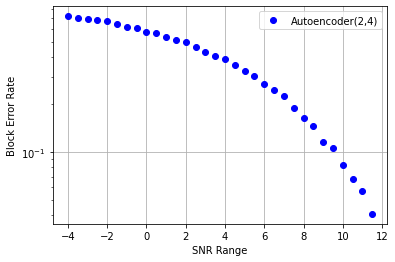

In [18]:

plt.plot(SNR_range, BER, 'bo',label='Autoencoder(2,4)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)